## Импортируем библиотеки

In [1]:
import re
import time
import json
import requests
import datetime
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from sklearn.svm import LinearSVR
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape


%matplotlib inline

# зафиксируем random_seed b test_size
RANDOM_SEED = 42
SPLIT_SIZE = 0.20

#### Задаём headers для парсинга

In [2]:
headers = {
'Host' : 'auto.ru',
'User-Agent' : 'Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:94.0) Gecko/20100101 Firefox/94.0',
'Accept' : 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
'Accept-Language' : 'en-US,en;q=0.5',
'Accept-Encoding' : 'gzip, deflate, br',
'Connection' : 'keep-alive',
'Cookie' : 'autoru_gdpr=1; suid=bc8be712d638a08131a6e9e0d202d740.c5b54afb905b8c06122ab3a791bcd52b; yandexuid=2760879651631376416; my=YysBAgA%3D; counter_ga_all7=2; credit_filter_promo_popup_closed=true; bltsr=1; autoru-visits-count=5; autoru_sid=a%3Ag619130a126cnq19ulaaft362m5p2vb2.ce95d73e09b71591f2b431378fbd3c26%7C1637509921806.604800.1BSyVNdQ_Jgiakk7ftwSsg.rxF87OjlP3hNehiaJwY7hz1CT9Y7Izf61mSqV5Ly0C8; autoruuid=g619130a126cnq19ulaaft362m5p2vb2.ce95d73e09b71591f2b431378fbd3c26; crookie=jpj0jVvWTMkqF2bLNEjq1Sm8BK5liRI8I2IDRbmuxJB1Z9qhACbqZpnyGeU1riNvks6acZdg/tULhikIF+VQKxi5Ddo=; deal_million_popup_page_seen=-1; credit_modal_autoshow_closed=true; _yasc=BXlfPgARlvaqwGCFNYlOD81UvI/rudyiPXKWSUFuIbFRxQ==; _csrf_token=cd33b362bade8bf97053fcccb6e8a730d67cea3890bc13dd; from_lifetime=1637870096528; from=direct; safe_deal_promo=0; yuidlt=1; cmtchd=MTYzNzg2MjAxMjI2OQ==; X-Vertis-DC=sas; los=1',
'Upgrade-Insecure-Requests' : '1',
'Sec-Fetch-Dest' : 'document',
'Sec-Fetch-Mode' : 'navigate',
'Sec-Fetch-Site' : 'none',
'Sec-Fetch-User' : '?1'
}
page_suffix = '?page='

интересующие нас колонки из test.csv

In [3]:
perks = ['Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'bodyType', 'brand', 'color', 'complectation_dict', 'description', 'engineDisplacement', 
      'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name', 
      'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id', 'super_gen', 
      'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'car_url']

#### Определяем функцию для парсинга страниц с сайта auto.ru

In [4]:
def get_ad_info(url, headers, characteristics):
    ad_info = dict()   
    r = requests.get(url, headers=headers)
    html = BeautifulSoup(r.content, 'html.parser')
    for li in html.find_all('li', 'CardInfoRow'):
        var1, var2 = tuple(li.children)
        key = var1.string
        value = var2.string
        if key in perks[:7]:
            ad_info[key] = value
    
    try:
        j1 = json.loads(html.script.string)
    except:
        return
    
    try:
        j2 = json.loads(html.find('script', id="initial-state").string)
    except:
        return
        
    for k in set(perks).intersection(set(j1)):
        ad_info[k] = j1[k]

    for l in set(perks).intersection(j1['vehicleEngine']):
        try:
            ad_info[l] = j1['vehicleEngine'][l]
        except:
            pass

    for m in set(perks).intersection(j2['card']['state']):
        try:
            ad_info[m] = j2['card']['state'][m]
        except:
            pass

    try: 
        ad_info['equipment_dict'] = j2['card']['vehicle_info']['equipment'] 
    except: 
        pass
    
    try: 
        ad_info['complectation_dict'] = j2['card']['vehicle_info']['complectation'] 
    except: 
        pass
    
    try: 
        ad_info['model_info'] = j2['card']['vehicle_info']['model_info'] 
    except: 
        pass
    
    try: 
        ad_info['model_name'] = j2['card']['vehicle_info']['model_info']['name'] 
    except: 
        pass
    
    try: 
        ad_info['super_gen'] = j2['card']['vehicle_info']['super_gen'] 
    except: 
        pass
    
    try: 
        ad_info['vendor'] = j2['card']['vehicle_info']['vendor'] 
    except: 
        pass
    
    try: 
        ad_info['sell_id'] = j2['card']['saleId'] 
    except: 
        pass
    

    try: 
        ad_info['price'] = j1['offers']['price'] 
    except: 
        pass
    
    try: 
        ad_info['priceCurrency'] = j1['offers']['priceCurrency'] 
    except: 
        pass
    
    try: 
        ad_info['car_url'] = j1['offers']['url'] 
    except: 
        pass
    

    ad_info['parsing_unixtime'] = time.time()

    return ad_info

#### Задаём список производителей автомобилей

Auto.ru выдает только первые 99 страниц, поэтому приходится задавать производителей вручную. Иначе будут спарсены 99 страниц (~3300 записей), которые не передают всей картины ценообразования.

In [ ]:
time_start = datetime.datetime.now()
makes = ['', 'renault', 'toyota', 'mercedes', 'audi', 'hyundai', 'ford', 'vaz', 'chevrolet', 'mitsubishi', 'volkswagen']
for make in makes:
    df = pd.DataFrame(columns=perks)
    print(f'{make=}')
    url = 'https://auto.ru/cars/' + make + '/all/'
    rng = range(1, 100)
    for page_num in rng:
        if page_num <=1:
            page_url = url
        else:
            page_url = url + page_suffix + str(page_num)
        res = requests.get(page_url, headers=headers)
        code = BeautifulSoup(res.content, 'html.parser')
        ad_links = code.find_all("a", class_="ListingItemTitle__link")
        for l in ad_links:
            link = l['href']
            car_info = get_ad_info(link, headers, perks)
            if car_info is None:
                pass
            else:
                df = df.append(car_info, ignore_index=True,)
            time.sleep(0.5)
    time_passed = datetime.datetime.now() - time_start
    print(f'{time_passed=}')
    df.to_csv('project6' + make + '.csv')

# Работа с данными

Из-за нестабильного интернета, первые файлы получились разбиты между собой. Импортируем всю собранную информацию.

In [5]:
df = pd.read_csv('project6.csv')
df = df.append(pd.read_csv('project6audi.csv'))
df = df.append(pd.read_csv('project6_ford_1.csv'))
df = df.append(pd.read_csv('project6_ford_3.csv'))
df = df.append(pd.read_csv('project6_ford_4.csv'))
df = df.append(pd.read_csv('project6hyundai.csv'))
df = df.append(pd.read_csv('project6mercedes.csv'))
df = df.append(pd.read_csv('project6renault.csv'))
df = df.append(pd.read_csv('project6toyota.csv'))
df = df.append(pd.read_csv('project6vaz.csv'))
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25711 entries, 0 to 25710
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 25711 non-null  int64  
 1   Unnamed: 0            25711 non-null  object 
 2   Владельцы             19388 non-null  object 
 3   Владение              2893 non-null   object 
 4   ПТС                   19388 non-null  object 
 5   Привод                19388 non-null  object 
 6   Руль                  19388 non-null  object 
 7   Состояние             19388 non-null  object 
 8   Таможня               19388 non-null  object 
 9   bodyType              25711 non-null  object 
 10  brand                 25711 non-null  object 
 11  color                 25711 non-null  object 
 12  complectation_dict    25708 non-null  object 
 13  description           25711 non-null  object 
 14  engineDisplacement    25711 non-null  object 
 15  enginePower        

In [6]:
# Отмечаем 0 тестовые данные, и 1 - данные, на которых мы будем тренироваться.
df['train'] = 1

df_test = pd.read_csv('test.csv')
df_test['train'] = 0
df = df.append(df_test)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60397 entries, 0 to 34685
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 25711 non-null  float64
 1   Unnamed: 0            25711 non-null  object 
 2   Владельцы             54074 non-null  object 
 3   Владение              14888 non-null  object 
 4   ПТС                   54073 non-null  object 
 5   Привод                54074 non-null  object 
 6   Руль                  54074 non-null  object 
 7   Состояние             54074 non-null  object 
 8   Таможня               54074 non-null  object 
 9   bodyType              60397 non-null  object 
 10  brand                 60397 non-null  object 
 11  color                 60397 non-null  object 
 12  complectation_dict    32126 non-null  object 
 13  description           60397 non-null  object 
 14  engineDisplacement    60397 non-null  object 
 15  enginePower        

In [7]:
df.loc[df['train'] == 0].shape

(34686, 36)

In [8]:
df.columns

Index(['index', 'Unnamed: 0', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'Состояние', 'Таможня', 'bodyType', 'brand', 'color',
       'complectation_dict', 'description', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage',
       'modelDate', 'model_info', 'model_name', 'name', 'numberOfDoors',
       'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id',
       'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor',
       'car_url', 'price', 'train'],
      dtype='object')

In [9]:
df.sample(3)

,index,Unnamed: 0,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,bodyType,...,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,car_url,price,train
11021,NaN,NaN,3 или более,NaN,Дубликат,задний,Левый,Не требует ремонта,Растаможен,седан,...,RUB,2007,1089688733,"{""id"":""20389997"",""name"":""530"",""nameplate"":""530...",SEDAN AUTOMATIC 3.0,автоматическая,EUROPEAN,https://auto.ru/cars/used/sale/bmw/5er/1089688...,NaN,0
14666,3668.0,3668,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,внедорожник 5 дв.,...,RUB,2020,1106011357-8d7f507b,"{'id': '21558856', 'name': 'I (X253) Рестайлин...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,https://auto.ru/cars/used/sale/mercedes/glc_kl...,3880000.0,1
17354,2668.0,2668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,внедорожник 5 дв.,...,RUB,2021,1105558777-93c38add,"{'id': '21570852', 'name': 'I', 'ru_name': '1'...",ALLROAD_5_DOORS VARIATOR 1.6,вариатор,EUROPEAN,https://auto.ru/cars/new/group/renault/arkana/...,2371900.0,1


Выделим признаки, с которыми будем работать. 
Убираем колонку "Владение", т.к. очень мало информации, и modelDate, она будет коррелировать с датой выпуска.
'vehicleConfiguration' и 'name' также удаляем, т.к. они состоят уже из имеющейся у нас информации. 
Удалим признак brand так как мы задаём марки автомобилей самостоятельно, то есть в тестовом наборе могут быть модели, которых нет у нас в наборе.

In [10]:
columns = ['sell_id','Владельцы','ПТС','Таможня','Привод','Руль','Состояние','mileage','bodyType',
           'color','engineDisplacement','enginePower', 'fuelType','vehicleTransmission','numberOfDoors',
           'productionDate','vendor','price', 'train']

In [11]:
df = df[columns]
df.head()

,sell_id,Владельцы,ПТС,Таможня,Привод,Руль,Состояние,mileage,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,numberOfDoors,productionDate,vendor,price,train
0,1105852895-ec19225f,2 владельца,Оригинал,Растаможен,полный,Левый,Не требует ремонта,89820,внедорожник 5 дв.,серый,2.0 LTR,225 N12,бензин,автоматическая,5,2013,EUROPEAN,1475000.0,1
1,1106089948-6939140b,2 владельца,Оригинал,Растаможен,передний,Левый,Не требует ремонта,94140,универсал 5 дв.,чёрный,2.0 LTR,190 N12,дизель,роботизированная,5,2017,EUROPEAN,2500000.0,1
2,1105739198-8ae650ca,NaN,NaN,NaN,NaN,NaN,NaN,0,лифтбек,синий,2.0 LTR,245 N12,бензин,роботизированная,5,2021,EUROPEAN,7927100.0,1
3,1105958789-92478ba6,2 владельца,Оригинал,Растаможен,полный,Левый,Не требует ремонта,119520,лифтбек,чёрный,2.0 LTR,211 N12,бензин,роботизированная,5,2013,EUROPEAN,1345000.0,1
4,1105279368-cd1d19a8,NaN,NaN,NaN,NaN,NaN,NaN,0,внедорожник 5 дв.,белый,2.0 LTR,249 N12,бензин,роботизированная,5,2021,EUROPEAN,5176300.0,1


#### Удалим дубликаты, которые образовались из-за перезапуска парсинга вследствии обрыва связи.

In [12]:
df.drop_duplicates(subset=['sell_id'], inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58136 entries, 0 to 34685
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sell_id              58136 non-null  object 
 1   Владельцы            52616 non-null  object 
 2   ПТС                  52615 non-null  object 
 3   Таможня              52616 non-null  object 
 4   Привод               52616 non-null  object 
 5   Руль                 52616 non-null  object 
 6   Состояние            52616 non-null  object 
 7   mileage              58136 non-null  object 
 8   bodyType             58136 non-null  object 
 9   color                58136 non-null  object 
 10  engineDisplacement   58136 non-null  object 
 11  enginePower          58136 non-null  object 
 12  fuelType             58136 non-null  object 
 13  vehicleTransmission  58136 non-null  object 
 14  numberOfDoors        58136 non-null  object 
 15  productionDate       58136 non-null 

#### Построим график пропусков

<AxesSubplot:>

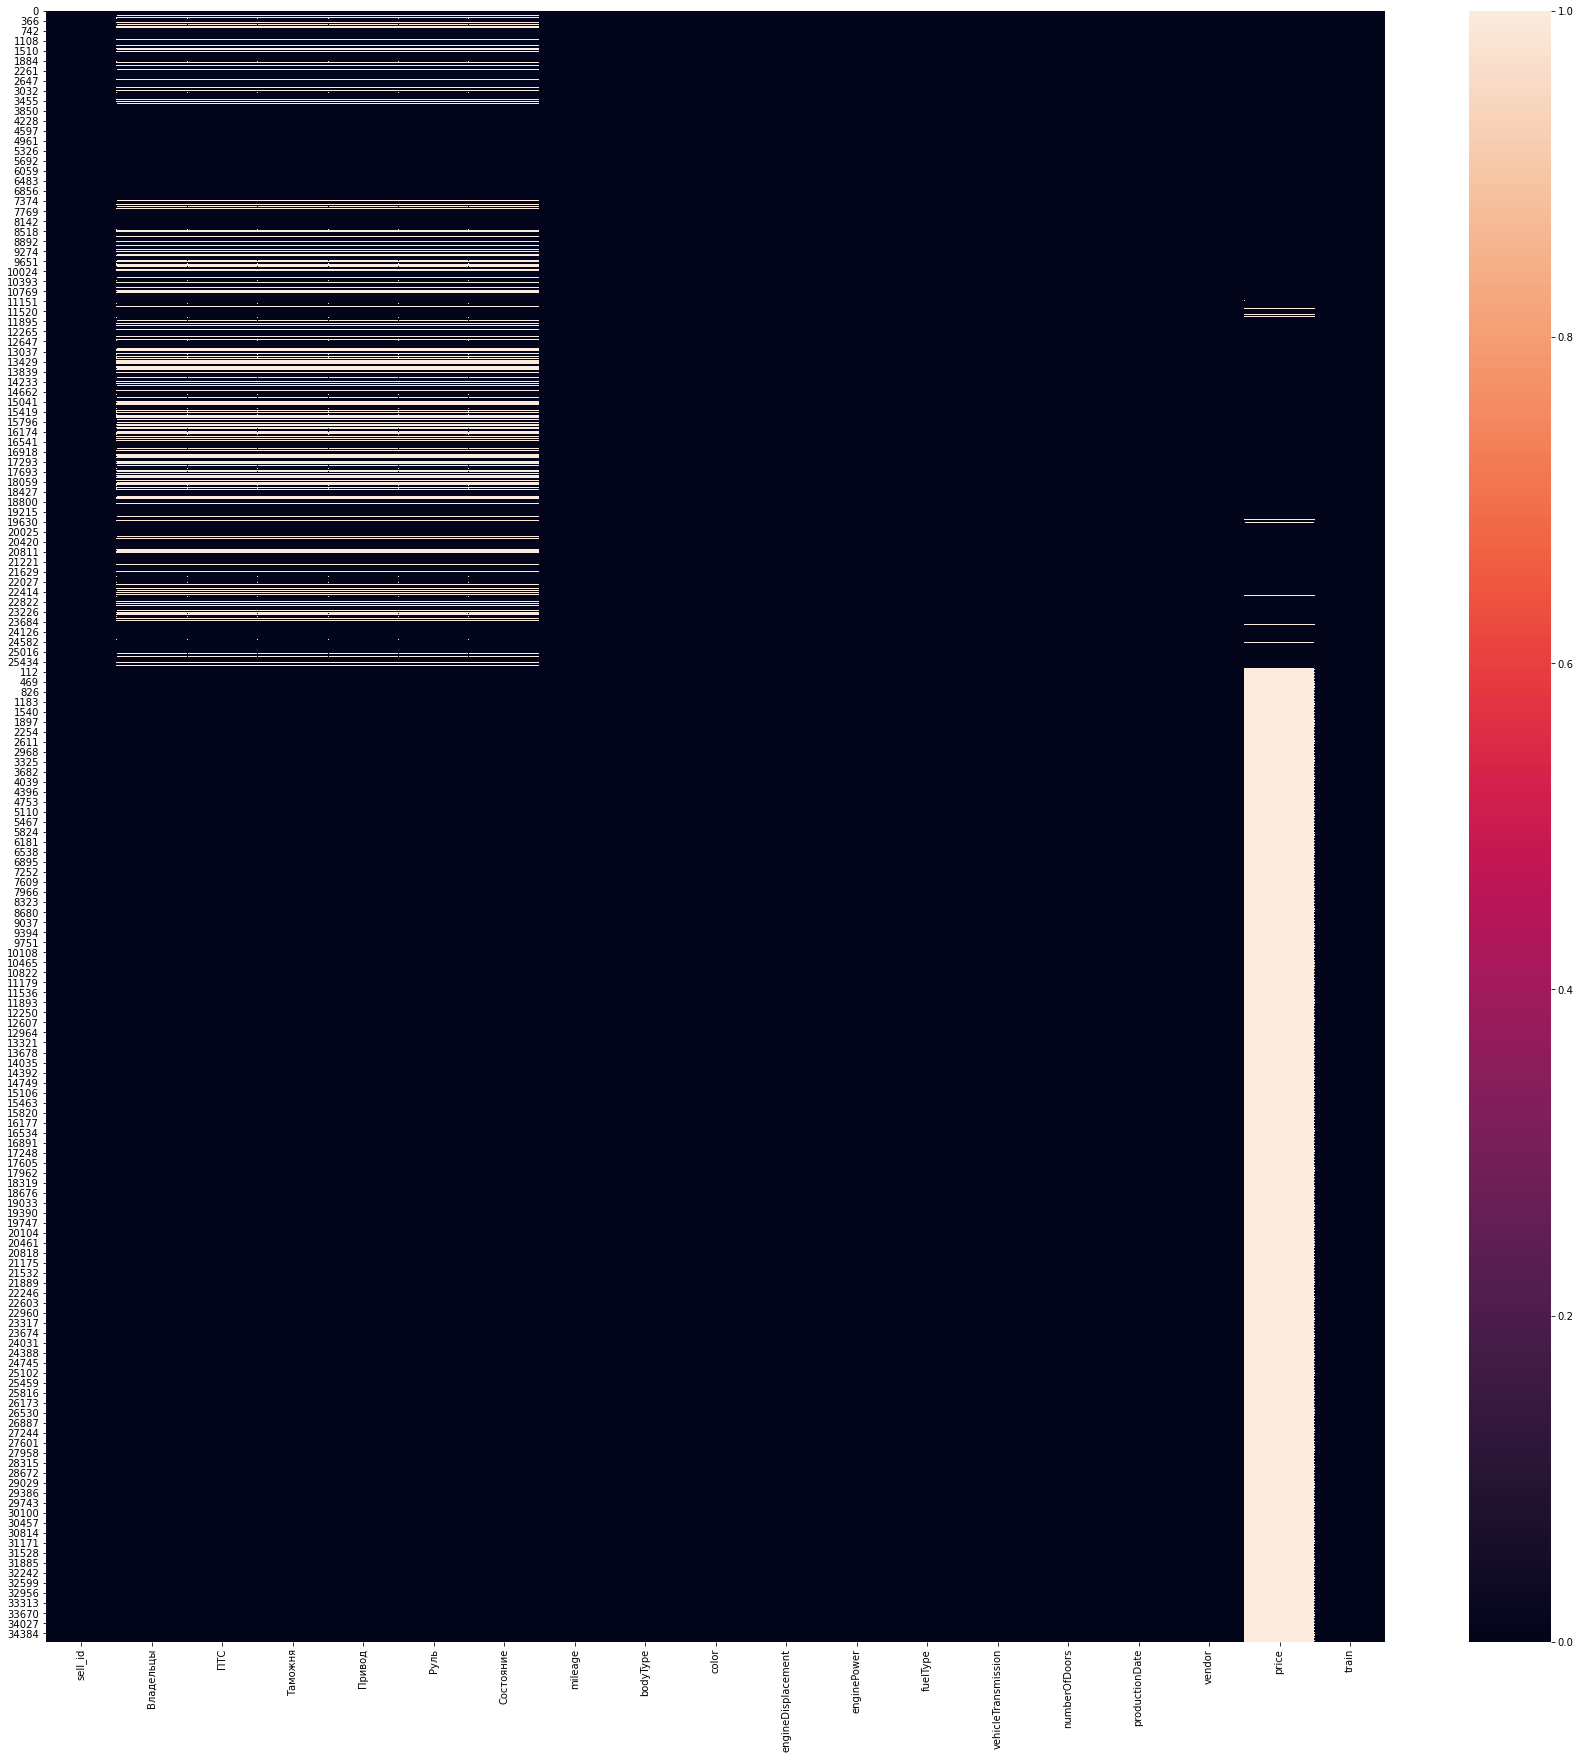

In [14]:
plt.subplots(figsize=(30, 30))
sns.heatmap(df.isnull())

#### Удалим записи, где нет цены

In [15]:
df_test = df.loc[df['train'] == 0, :]
df_train = df.loc[(df['train'] == 1) & (df['price'] > 0), :]

In [16]:
df = df_test.append(df_train)

#### Смотрим колонку Владельцы

In [17]:
df['Владельцы'].value_counts()

3 или более    22432
1 владелец     16531
2 владельца    13401
Name: Владельцы, dtype: int64

In [18]:
# предположим что пропуски относятся к новым автомобилям, поэтому заполним их "0"
df['Владельцы'] = df['Владельцы'].fillna(0)

In [19]:
# это количественный признак и преобразуем его, оставив только количество владельцев
df['Владельцы'] = df['Владельцы'].apply(lambda x: 1 if str(x).startswith('1') else 2 if str(x).startswith('2') else 3 if str(x).startswith('3') else x)

#### Смотрим колонку ПТС

In [20]:
df['ПТС'].value_counts()

Оригинал    45746
Дубликат     6617
Name: ПТС, dtype: int64

In [21]:
# это категориальный признак, преобразуем его
df['ПТС'] = df['ПТС'].apply(lambda x: 1 if x == 'Оригинал' else 0)

#### Смотрим колонку Привод

In [22]:
df['Привод'].value_counts()

передний    25701
полный      21586
задний       5077
Name: Привод, dtype: int64

In [23]:
# применяем get_dummies и удаляем признак "Привод"
df = pd.concat([df, pd.get_dummies(df['Привод'])], axis=1)
df.drop(columns=['Привод'], inplace= True)

#### Смотрим колонку Руль

In [24]:
df['Руль'].value_counts()

Левый     50643
Правый     1721
Name: Руль, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


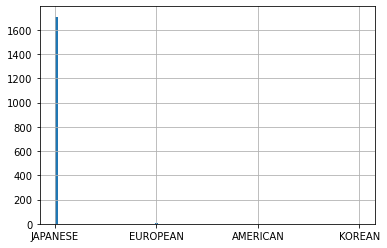

In [25]:
# Проверим корреляцию стороный руля и страны происхождения. Очевидно, что правосторонний руль у автомобилей произвденных в Японии. 
print(df['vendor'][df['Руль'] == 'Правый'].hist(bins=100))

In [26]:
# Заполним nans исходя из предыдущего вывода.
def fill_steering(row):
    if pd.isnull(row['Руль']) and row['vendor'] == 'JAPANESE':
        return 1
    elif pd.isnull(row['Руль']) and row['vendor'] != 'JAPANESE':
        return 0
    elif row['Руль'] == 'Левый':
        return 0
    elif row['Руль'] == 'Правый':
        return 1

In [27]:
# преобразуем его, применив функцию
df['Руль'] = df.apply(fill_steering, axis=1)

#### Смотрим колонку Состояние

In [28]:
df['Состояние'].value_counts()

Не требует ремонта    52364
Name: Состояние, dtype: int64

In [29]:
# предположим что пропуски относятся к новым автомобилям, делаем вывод что все автомобили не требуют ремонта, 
# поэтому удаляем признак
df.drop(columns=['Состояние'], inplace= True)

#### Смотрим колонку Таможня

In [30]:
df['Таможня'].value_counts()

Растаможен    52364
Name: Таможня, dtype: int64

In [31]:
# предположим что пропуски относятся к автомобилям,который растаможен делаем вывод что все автомобили растаможены,
# поэтому удаляем признак
df.drop(columns=['Таможня'], inplace= True)

#### Смотрим колонку bodyType

In [32]:
df['bodyType'].value_counts()

внедорожник 5 дв.          21391
седан                      21026
хэтчбек 5 дв.               4653
лифтбек                     2735
универсал 5 дв.             2629
минивэн                     1471
купе                        1202
компактвэн                   728
хэтчбек 3 дв.                704
пикап двойная кабина         400
внедорожник 3 дв.            282
купе-хардтоп                 204
фургон                       157
кабриолет                    121
родстер                      114
седан-хардтоп                 15
микровэн                      11
пикап полуторная кабина       11
лимузин                        8
пикап одинарная кабина         8
седан 2 дв.                    6
внедорожник открытый           3
тарга                          2
хэтчбек 4 дв.                  2
фастбек                        1
Name: bodyType, dtype: int64

In [33]:
# применяем get_dummies
df = pd.concat([df, pd.get_dummies(df['bodyType'])], axis=1)
df.drop(columns=['bodyType'], inplace=True)

#### Смотрим колонку color

In [34]:
df = pd.concat([df, pd.get_dummies(df['color'])], axis=1)
df.drop(columns=['color'], inplace= True)

#### Смотрим колонку engineDisplacement

In [35]:
df['engineDisplacement'].value_counts()

1.6 LTR    12786
2.0 LTR    12483
3.0 LTR     5377
1.8 LTR     4409
2.5 LTR     3608
1.4 LTR     2552
3.5 LTR     2389
2.4 LTR     2005
1.5 LTR     1549
1.3 LTR     1003
4.0 LTR      817
2.8 LTR      690
1.2 LTR      536
4.5 LTR      536
4.7 LTR      522
5.5 LTR      520
2.1 LTR      515
2.2 LTR      489
4.4 LTR      447
2.3 LTR      440
2.9 LTR      424
3.2 LTR      388
2.7 LTR      367
4.2 LTR      303
1.7 LTR      289
3.7 LTR      255
1.9 LTR      239
3.6 LTR      202
5.0 LTR      190
5.6 LTR      171
4.6 LTR      164
5.7 LTR      153
 LTR         126
3.1 LTR      125
1.0 LTR       87
4.8 LTR       84
2.6 LTR       76
3.8 LTR       69
6.0 LTR       66
3.3 LTR       54
5.4 LTR       53
0.7 LTR       53
3.4 LTR       51
4.1 LTR       43
6.2 LTR       37
4.3 LTR       35
5.2 LTR       23
5.9 LTR       21
1.1 LTR       12
5.8 LTR       12
6.3 LTR       11
0.8 LTR        8
4.9 LTR        7
6.6 LTR        6
6.1 LTR        3
6.8 LTR        2
5.3 LTR        1
3.9 LTR        1
Name: engineDi

In [36]:
# Преобразуем признак в численный и сразу же удаляем пропуски
df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: float(str(x).replace('LTR', '')) if str(x).replace('LTR', '').strip() != '' else 1.6)

In [37]:
df.dropna(subset=['engineDisplacement'],inplace = True)

In [38]:
# Целевые тестовые данные
XX = df.loc[df['train'] == 0].drop(columns=['price', 'sell_id'])
XX.shape

(34686, 56)

#### Смотрим колонку enginePower

In [39]:
# этот признак является количесвенным, поэтому выделим полезную часть
df['enginePower'] = df['enginePower'].apply(lambda x: x.split()[0])

In [40]:
df['enginePower']

0        105
1        110
2        152
3        110
4        152
        ... 
25706    122
25707     98
25708    106
25709     87
25710    113
Name: enginePower, Length: 57884, dtype: object

#### Смотрим колонку fuelType

In [41]:
df['fuelType'].value_counts()

бензин     48393
дизель      9043
гибрид       306
электро      126
газ           16
Name: fuelType, dtype: int64

In [42]:
# преобразуем данные этой колонки, используя get_dummies
df = pd.concat([df, pd.get_dummies(df['fuelType'])], axis=1)# применяем get_dummies
df.drop(columns=['fuelType'], inplace= True)

#### Смотрим колонку numberOfDoors

In [44]:
# оставляем без изменений
df['numberOfDoors'].value_counts()

5    32914
4    22237
2     1686
3     1046
0        1
Name: numberOfDoors, dtype: int64

#### Смотрим колонку productionDate

In [45]:
# оставляем без изменений
df['productionDate'].value_counts()

2021    6317
2012    3971
2013    3672
2011    3565
2008    3534
        ... 
1957       1
1961       1
1963       1
1970       1
1904       1
Name: productionDate, Length: 71, dtype: int64

#### Смотрим колонку vehicleTransmission

In [46]:
# преобразуем данные этой колонки, используя get_dummies
df['vehicleTransmission'].value_counts()

автоматическая      30231
механическая        14970
роботизированная     6875
вариатор             5808
Name: vehicleTransmission, dtype: int64

In [47]:
df = pd.concat([df, pd.get_dummies(df['vehicleTransmission'])], axis=1)
df.drop(columns=['vehicleTransmission'], inplace= True)

#### Смотрим колонку vendor

In [48]:
# удалим пропуски "vendor"
df.dropna(subset=['vendor'],inplace = True)
df.vendor.value_counts()

EUROPEAN    30901
JAPANESE    17274
KOREAN       3458
AMERICAN     3279
RUSSIAN      2969
Name: vendor, dtype: int64

In [49]:
df = pd.concat([df, pd.get_dummies(df['vendor'])], axis=1)
df.drop(columns=['vendor'], inplace= True)

<AxesSubplot:>

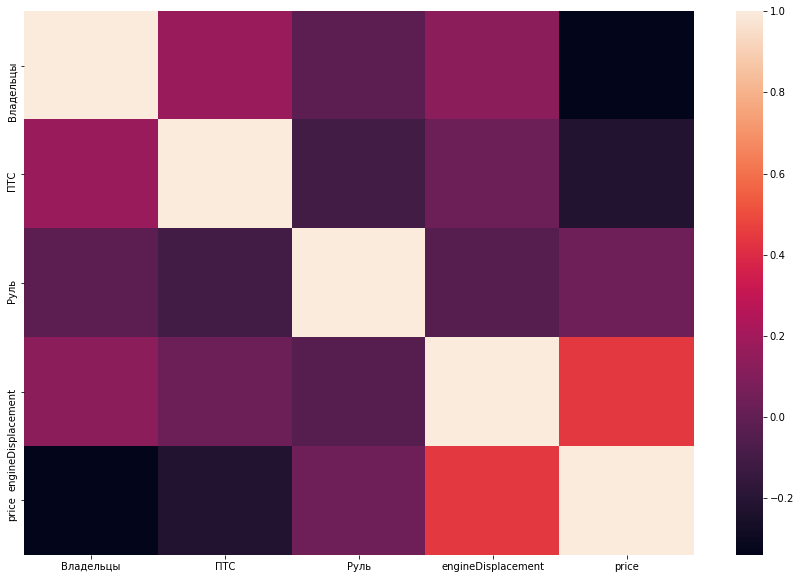

In [50]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.loc[:, 'Владельцы':'price'].corr())

#### Посмотрим на колонки mileage и Владельцы
Удалим mileage и валдельцы, т.к. они сильно коррелируют с ProductionDate

In [51]:
df.drop(columns=['mileage','Владельцы'], inplace= True)

#### нормализуем данные 'engineDisplacement', 'enginePower', 'productionDate'

In [52]:
scaler = MinMaxScaler()
columns_to_scale = ['engineDisplacement', 'enginePower', 'productionDate']
scaler.fit(df[columns_to_scale])
df[columns_to_scale] = scaler.transform(df[columns_to_scale])

In [53]:
df.loc[df['train']==0]

,sell_id,ПТС,Руль,engineDisplacement,enginePower,numberOfDoors,productionDate,price,train,задний,...,электро,автоматическая,вариатор,механическая,роботизированная,AMERICAN,EUROPEAN,JAPANESE,KOREAN,RUSSIAN
0,1100575026,1,0,0.081967,0.144393,5,0.940171,NaN,0,0,...,0,0,0,0,1,0,1,0,0,0
1,1100549428,1,0,0.147541,0.152074,5,0.965812,NaN,0,0,...,0,0,0,1,0,0,1,0,0,0
2,1100658222,1,0,0.180328,0.216590,5,0.940171,NaN,0,0,...,0,0,0,0,1,0,1,0,0,0
3,1100937408,1,0,0.147541,0.152074,5,0.940171,NaN,0,0,...,0,1,0,0,0,0,1,0,0,0
4,1101037972,1,0,0.180328,0.216590,5,0.923077,NaN,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,1101369263,1,0,0.147541,0.192012,4,0.940171,NaN,0,1,...,0,1,0,0,0,0,1,0,0,0
34682,1101369581,1,0,0.213115,0.274962,4,0.974359,NaN,0,0,...,0,1,0,0,0,0,1,0,0,0
34683,1101364889,0,0,0.295082,0.244240,4,0.794872,NaN,0,1,...,0,1,0,0,0,0,1,0,0,0
34684,1101362518,1,0,0.213115,0.265745,5,0.931624,NaN,0,0,...,0,1,0,0,0,0,1,0,0,0


## Выделим целевую переменную и разделим выборку на train и validate

In [54]:
X = df.loc[df['train'] == 1].drop(columns=['price','sell_id'])
y = df.loc[df['train'] == 1]['price'] / 1000000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [55]:
# обучаем модель GradientBoostingRegressor, измеряем точность
reg = GradientBoostingRegressor(random_state=RANDOM_SEED)
reg.fit(X_train, y_train)
predict = reg.predict(X_test)
 
#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 25.15%


#### Точность модели не очень хорошая

<AxesSubplot:>

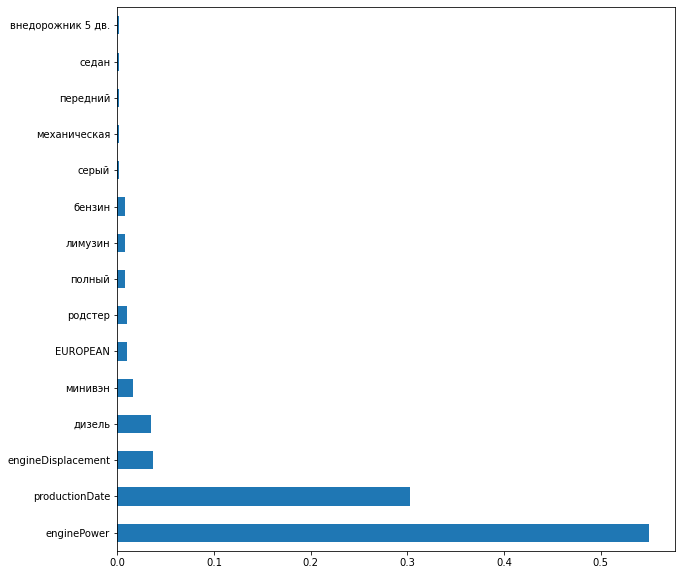

In [56]:
# Посмотрим какие признаки больше всего влияют на модель.
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [57]:
# попробуем нормализовать целевую переменную.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_SIZE, shuffle=True, random_state=RANDOM_SEED)
y_train = np.log(y_train)
reg = GradientBoostingRegressor(random_state=RANDOM_SEED)
reg.fit(X_train, y_train)
predict = np.exp(reg.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 16.72%


#### Точность улучшилась

<AxesSubplot:>

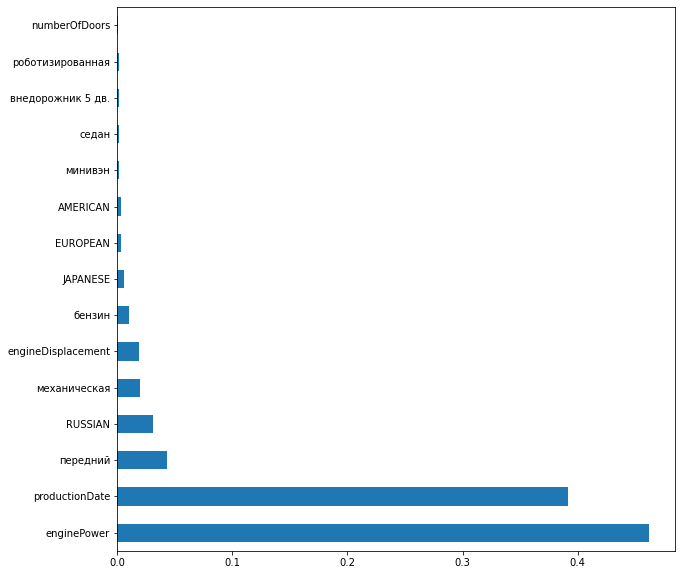

In [58]:
# Посмотрим какие признаки больше всего влияют на модель.
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

#### Проверим модель на преобучение

In [59]:
y_pred_t = np.exp(reg.predict(X_train))
mape_train = mape(np.exp(y_train),y_pred_t)
print('[train] mape = {:.2f}%'.format(mape_train*100))
y_pred_v = np.exp(reg.predict(X_test))
mape_val = mape(y_test, y_pred_v)
print('[valid] mape = {:.2f}%'.format(mape_val*100))

[train] mape = 16.53%
[valid] mape = 16.72%


In [60]:
#Видим, что точность при валидации и тестировании приблизительно равны, делаем вывод, что преобучение отсутствует

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_SIZE, shuffle=True, random_state=RANDOM_SEED)
model = CatBoostRegressor(iterations = 10000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         )

In [62]:
predict = (model.predict(X_test))


In [63]:
estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=RANDOM_SEED, max_iter=10000)),
    ('rfr', RandomForestRegressor(n_estimators=10,
                                          random_state=RANDOM_SEED))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=KNeighborsRegressor(n_neighbors=20,
                                            metric='euclidean')
)
from sklearn.model_selection import train_test_split

print(reg.fit(X_train, y_train).score(X_test, y_test))

0.940279022801546


In [64]:
predicted = reg.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(predicted, y_test))*100:0.2f}%")

Точность модели по метрике MAPE: 14.10%


## Предсказываем на тестовой выборке

In [173]:
XX = df.loc[df['train'] == 0].drop(['sell_id', 'price'], axis=1)
ids = df.loc[df['train'] == 0]['sell_id']
to_submit = pd.DataFrame(ids, columns=['sell_id'])
XX.shape

(34686, 65)

In [174]:
predicted = reg.predict(XX) * 1000000

#### Добавляем поправку на инфляцию и округляем до тысяч

In [175]:
predicted = predicted * 0.4 // 1000 * 1000

In [176]:
predicted[:12]

array([428000., 430000., 626000., 417000., 494000., 689000., 465000.,
       375000., 971000., 453000., 414000., 885000.])

In [177]:
to_submit['price'] = predicted

In [178]:
to_submit.to_csv('to_submit.csv', columns=['sell_id', 'price'], index=False)

In [172]:
to_submit.shape

(34686, 2)